[View in Colaboratory](https://colab.research.google.com/github/adowaconan/Deep_learning_fMRI/blob/master/3_image_classification_with_CNN,_transfer_learning,_cat_vs_dog.ipynb)

This script is demonstrates how to implement a multi-layer convolutional neural network, and utilize “transfer learning” to shorten our time of training a model.

Most of the time, for neuroimaging, we don't have more than millions of instances to train a multi-layer CNN model that is deep (more than 20 layers) and/or wide (each layer contains more than 100 neurons/kernels). 
 
Thus, transferring a trained model from a similar domain benefits us by providing a useful feature extractor that extracts meaningful* (or maybe not) features and ensemble them and pass these ensembled features to the next layer.

<bt />With only a few instances, say 1000, you cannot train a model that performs well, aka generalization through cross validation. This is mainly because the model contains millions of parameters (deep learning model) while the number of features is way less than that.  In the domain of natural images, the data shape is visually 2D, with an extra dimension of the color channel. There are lots of models proposed to solve the  [imagenet classification problem](https://en.wikipedia.org/wiki/ImageNet), which is now moving on to [object dectection problem](https://www.kaggle.com/c/imagenet-object-detection-challenge) with the same data but adding object labels for each image. 
<br />Among these proposed models, many of them are deep learning models that employs multi-layer 2D CNN model. From these models, the best model from each year provides us with some insights about computer vision. One of the insights is that the first few layers of the CNN are always similar from model to model. In other words, they tend to be lower [feature filters](http://yosinski.com/static/proj/deepvis_all_layers.jpg). The take-home point from this insight is that we should not randomly initialize our deep learning models every time we want to classify categories.  **Therefore, we should have some pre-trained models or low level layers ready for us to extract features without tuning the weights too much.** 
<br />This is called "[transfer learning](http://cs231n.github.io/transfer-learning/)". For instance, [VGG16](http://www.robots.ox.ac.uk/~vgg/research/very_deep/) is one of the models that could classify the imagenet problem with 7.5% testing error. We could easily build a deeper model on top of VGG16, say adding 3 layers, aka VGG19, and we could improve the performance to 7.3% testing error. More often, the reason we use transfer learning is because we don't have enough data to tune many parameters or we don't have the resource or time to tune these many parameter. 
<br />Here, to demonstrate the efficiency of transfer learning, we are going to:
1. Build a 2D CNN model on top of VGG19
2. Only train the last layer of our model
3. Only have 1000 instances
4. Only go through the data 10 times

In [1]:
# first we load different types of architectures from Keras library. 

from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.applications import InceptionV3
from keras.applications import Xception # TensorFlow ONLY
from keras.applications import VGG16
from keras.applications import VGG19
from keras.applications import imagenet_utils  # this is for making the operations on image e.g cropping them 
# now we load the functions for importing the image, converting it to array and then using an Image Data generator 

from keras.preprocessing.image import img_to_array  
from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# keras makes it easy to download pre-trained models

In [2]:
model_vgg19 = VGG19(include_top=False, # do not include the classifier
                    weights='imagenet', # get the pretrained weights
                    input_tensor=None, # don't know what this is
                    input_shape=(128,128,3), # decide the input shape
                    pooling='avg', # use global average for the pooling
                    classes=1000)# doesen't matter

80150528/80134624 [==============================] - 7s 0us/step


In [3]:
model_vgg19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

# Showing how a typical VGG19 network works

In [4]:
from IPython.display import Image
from IPython.core.display import HTML
print('source: {},{}'.format('Shape Selectivity of Middle Superior Temporal Sulcus Body Patch Neurons','http://www.eneuro.org/content/4/3/ENEURO.0113-17.2017/F10'))
Image(url='http://www.eneuro.org/content/eneuro/4/3/ENEURO.0113-17.2017/F10.large.jpg')

source: Shape Selectivity of Middle Superior Temporal Sulcus Body Patch Neurons,http://www.eneuro.org/content/4/3/ENEURO.0113-17.2017/F10


# Typical ways to get the data from google drive

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

import numpy as np

file_id = '1MzKfuNscX8hgufoRD5XZlHvnGZWh1x-4' # the shareable google drive ID for the zip file, you can get this from your google drive
zip_import = drive.CreateFile({'id':file_id})
zip_import.GetContentFile('images.zip')

import zipfile
zip_ref = zipfile.ZipFile('images.zip', 'r')
zip_ref.extractall('images')#eventually we will get /content/images/images
zip_ref.close()

In [6]:
import os
os.listdir('/content/images/images')

['dog', 'cat']

In [7]:
!pip install tqdm

    100% |████████████████████████████████| 51kB 3.6MB/s 


# We are not going to load all the data to google colab's RAM, but instead, we use a very memory-efficient technique called "flow from directory". In other words, since we are going to process and learn the images with mini-batches, we only load the mini-batches as we will use them. A typical mini-batch size is 32

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


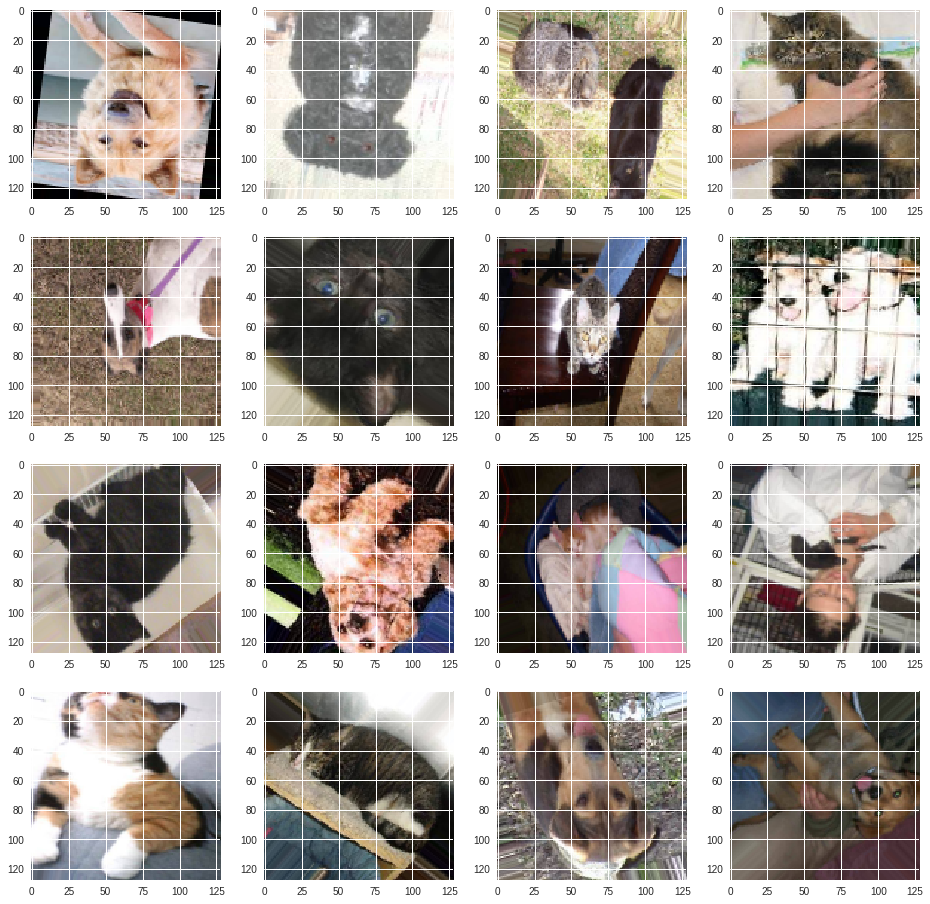

In [8]:
datagen = ImageDataGenerator(rescale=1./255,# to rescale the values to (0,1)
                             horizontal_flip=True,# have some of the images horizontally flipped
                             vertical_flip=True,#have some of the images vertically flipped
                             rotation_range=45,# have some of the images clock-wise rotated
                             shear_range=0.1,# have some of the images sheared
                             zoom_range=0.1,# have some of the images zoomed in
                             validation_split=0.2)# split 20% of the images as validation data
train_generator = datagen.flow_from_directory('/content/images/images',
                                             seed=12345,# just a personal favorite value, but seriously, seeding is very important for reproducibility
                                             target_size=(128,128),# making sure the data is in the target shape, and it will know there are 3 color-channels
                                             batch_size=32,# mini-batch size
                                             class_mode='categorical',# making one-hot labels, so that our model could provide probabilistic predictions
                                             shuffle=True,# shuffle the data within each epoch
                                             subset='training')# this is the generator for training data
valid_generator = datagen.flow_from_directory('/content/images/images',
                                             seed=12345,
                                             target_size=(128,128),
                                             batch_size=32,
                                             class_mode='categorical',
                                             shuffle=False,
                                             subset='validation')
temp,j = train_generator.next()
fig,axes = plt.subplots(nrows=4,ncols=4,figsize=(16,16))
for ii,ax in enumerate(axes.flatten()):
    ax.imshow(temp[ii])
    

# All I add is a dropout layer and a softmax classifier

In [15]:
from keras.models import Model
from keras.layers import Dense,Dropout
from keras import optimizers,metrics,losses

for i,layer in enumerate(model_vgg19.layers[:-2]):
    layer.trainable = False # freeze the weights so that they would not be updated during training

Encoder = model_vgg19.output # get the vgg19 model to its last layer
Encoder = Dropout(0.5)(Encoder)# add a dropout layer
output = Dense(2,activation='softmax',)(Encoder)# add a classifier
model = Model(model_vgg19.input,output)# make the model
model.compile(optimizer=optimizers.adam(),# compile the model with an optimizer
              loss=losses.binary_crossentropy,# compile the model with a loss function
              metrics=['acc'])# compile the model with a metric, and you can have multiple ones
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [0]:
pred = model.predict_generator(valid_generator,)


[(0, 1),
 Text(0,0.5,u'True positive rate'),
 (0, 1),
 Text(0.5,0,u'False positive rate')]

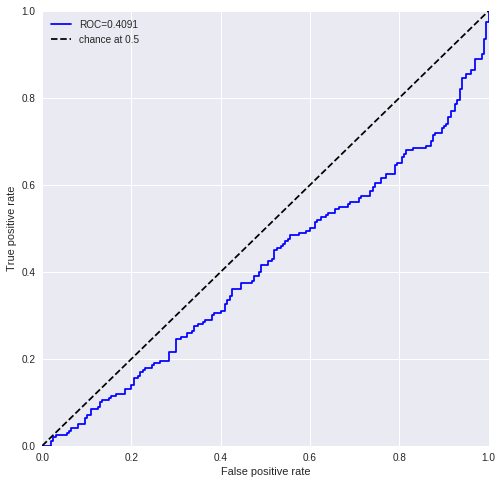

In [17]:
from sklearn import metrics
scores = metrics.roc_auc_score(valid_generator.classes,pred[:,-1])
fpr,tpr,t = metrics.roc_curve(valid_generator.classes,pred[:,-1])
fig,ax = plt.subplots(figsize=(8,8))
ax.plot(fpr,tpr,color='blue',label='ROC={:.4f}'.format(scores))
ax.plot([0, 1], [0, 1],color='black',linestyle='--',label='chance at 0.5')
ax.legend()
ax.set(xlim=(0,1),ylim=(0,1),xlabel='False positive rate',
       ylabel='True positive rate')

In [0]:
from keras.callbacks import ModelCheckpoint,TensorBoard
file_path = '/content/model' # define the path for saving the model
if not os.path.exists(file_path):
    os.mkdir(file_path)
checkPoint = ModelCheckpoint(file_path+'/CNN.best.hdf5',monitor='val_loss',save_best_only=True,mode='min',period=1,verbose=1)


tensorboard = TensorBoard(log_dir='/content/tensorboard', histogram_freq=0, write_graph=True, write_images=True)
callback_list = [checkPoint,tensorboard]

In [19]:
model.fit_generator(train_generator,epochs=10,validation_data=valid_generator,callbacks=callback_list)

Epoch 1/10
50/50 [==============================] - 470s 9s/step - loss: 0.7883 - acc: 0.4925 - val_loss: 0.6817 - val_acc: 0.5750

Epoch 00001: val_loss improved from inf to 0.68174, saving model to /content/model/CNN.best.hdf5
Epoch 2/10
50/50 [==============================] - 447s 9s/step - loss: 0.7041 - acc: 0.5425 - val_loss: 0.6600 - val_acc: 0.6475

Epoch 00002: val_loss improved from 0.68174 to 0.66003, saving model to /content/model/CNN.best.hdf5
Epoch 3/10
50/50 [==============================] - 438s 9s/step - loss: 0.6775 - acc: 0.5700 - val_loss: 0.6329 - val_acc: 0.6975

Epoch 00003: val_loss improved from 0.66003 to 0.63291, saving model to /content/model/CNN.best.hdf5
Epoch 4/10
50/50 [==============================] - 444s 9s/step - loss: 0.6715 - acc: 0.5900 - val_loss: 0.6273 - val_acc: 0.6775

Epoch 00004: val_loss improved from 0.63291 to 0.62730, saving model to /content/model/CNN.best.hdf5
Epoch 5/10
 9/50 [====>.........................] - ETA: 4:50 - loss: 0.

50/50 [==============================] - 571s 11s/step - loss: 0.6546 - acc: 0.6012 - val_loss: 0.6112 - val_acc: 0.6950

Epoch 00005: val_loss improved from 0.62730 to 0.61119, saving model to /content/model/CNN.best.hdf5
Epoch 6/10
50/50 [==============================] - 497s 10s/step - loss: 0.6366 - acc: 0.6338 - val_loss: 0.5959 - val_acc: 0.7350

Epoch 00006: val_loss improved from 0.61119 to 0.59591, saving model to /content/model/CNN.best.hdf5
Epoch 7/10
50/50 [==============================] - 446s 9s/step - loss: 0.6302 - acc: 0.6344 - val_loss: 0.5955 - val_acc: 0.7100

Epoch 00007: val_loss improved from 0.59591 to 0.59553, saving model to /content/model/CNN.best.hdf5
Epoch 8/10
50/50 [==============================] - 440s 9s/step - loss: 0.6127 - acc: 0.6650 - val_loss: 0.5762 - val_acc: 0.7425

Epoch 00008: val_loss improved from 0.59553 to 0.57623, saving model to /content/model/CNN.best.hdf5
Epoch 9/10
 9/50 [====>.........................] - ETA: 4:43 - loss: 0.6102 

50/50 [==============================] - 434s 9s/step - loss: 0.6044 - acc: 0.6800 - val_loss: 0.5814 - val_acc: 0.7200

Epoch 00009: val_loss did not improve from 0.57623
Epoch 10/10
50/50 [==============================] - 435s 9s/step - loss: 0.6107 - acc: 0.6600 - val_loss: 0.5637 - val_acc: 0.7725

Epoch 00010: val_loss improved from 0.57623 to 0.56368, saving model to /content/model/CNN.best.hdf5


In [0]:
pred = model.predict_generator(valid_generator,)

[(0, 1),
 Text(0,0.5,u'True positive rate'),
 (0, 1),
 Text(0.5,0,u'False positive rate')]

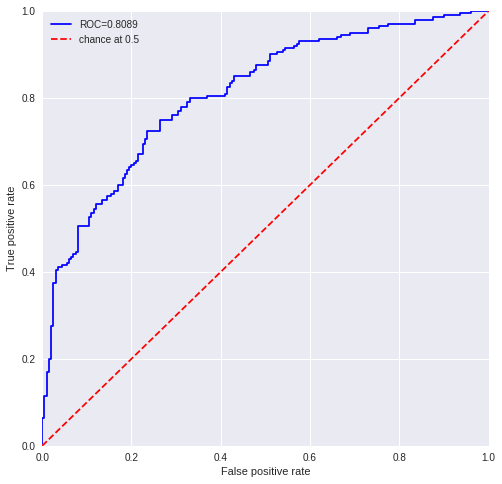

In [21]:
scores = metrics.roc_auc_score(valid_generator.classes,pred[:,-1])
fpr,tpr,t = metrics.roc_curve(valid_generator.classes,pred[:,-1])
fig,ax = plt.subplots(figsize=(8,8))
ax.plot(fpr,tpr,color='blue',label='ROC={:.4f}'.format(scores))
ax.plot([0, 1], [0, 1],color='red',linestyle='--',label='chance at 0.5')
ax.legend()
ax.set(xlim=(0,1),ylim=(0,1),xlabel='False positive rate',
       ylabel='True positive rate')

In [0]:
# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a file.
uploaded = drive.CreateFile({'title': 'CNN.best.hdf5'})# title you want in the drive
uploaded.SetContentFile("/content/CNN.best.hdf5")# path from the colab content folder
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))